# Estimate the seismic moments and moment magnitudes

For events that were accurately relocated ($h_{max,unc} < 5$ km) with `NonLinLoc`, we can try to estimate their seismic moment $M_0$ and moment magnitude $M_w$ by fitting their network-averaged, path-corrected displacement spectrum with the omega-square model (Brune or Boatwright model).

We recall that:
$$ M_w = \frac{2}{3} \left( \log M_0 - 9.1 \right)\quad (1), $$
with $M_0$ in N.m.

Models of displacement spectra in the far-field predict the shape:
$$ S(f) = \dfrac{\Omega_0}{\left( 1 + (f/f_c)^{\gamma n} \right)^{1/\gamma}}\quad (2).$$
Equation (2) is a general expression where $f_c$ is the corner frequency and $n$ controls the high-frequency fall-off rate of the spectrum (typically $n \approx 2$) and $\gamma$ controls the sharpness of the spectrum's corner. Two special cases of (2) are:
- The Brune spectrum ($n=2$, $\gamma = 1$):
$$ S_{\mathrm{Brune}}(f) = \dfrac{\Omega_0}{1 + (f/f_c)^{2}}\quad (3)$$
- Boatwright's spectrum ($n=2$, $\gamma=2$):
$$ S_{\mathrm{Boatwright}}(f) = \dfrac{\Omega_0}{\left( 1 + (f/f_c)^{2 n} \right)^{1/2}}\quad (4)$$

The low-frequency plateau $\Omega_0$ is proportional to the seismic moment $M_0$.

$$ \Omega^{P/S}_0 = \dfrac{M_0 R^{P/S}}{2 \rho v_{P/S}^3 r} \exp \left( - \dfrac{\pi \tau^{P/S} f}{Q^{P/S}} \right)\quad (5). $$

In Equation (5), the P/S superscript is for P and S wave. $R^{P/S}$ is the average radiation pattern ($R^P = \sqrt{4/15}$ and $R^S = \sqrt{2/5}$, see Aki and Richards, 2002), $\rho$ and $v_{P/S}$ are the medium density and P/S-wave velocity at the source, respectively, $r$ is the source-receiver distance, $\tau^{P/S}$ is the P/S travel time and $Q^{P/S}$ is the P/S attenuation factor.More details in Boatwright, 1978.


References
----------

Aki, K., & Richards, P. G. (2002). Quantitative seismology.

Boatwright, J. (1978). Detailed spectral analysis of two small New York State earthquakes. Bulletin of the Seismological Society of America, 68(4), 1117-1131.

In [1]:
import os
# choose the number of threads you want to limit the computation to
n_CPUs = 24
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import BPMF
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from BPMF.data_reader_examples import data_reader_mseed
from time import time as give_time

In [2]:
INPUT_DB_FILENAME = "reloc_bp.h5"
NETWORK_FILENAME = "network.csv"

In [3]:
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()

## Load the metadata of the previously detected events

This is similar to what we did in 6_relocate.

In [4]:
backprojection_events = []
with h5.File(os.path.join(BPMF.cfg.OUTPUT_PATH, INPUT_DB_FILENAME), mode="r") as fin:
    for group_id in fin.keys():
        backprojection_events.append(
            BPMF.dataset.Event.read_from_file(
                INPUT_DB_FILENAME,
                db_path=BPMF.cfg.OUTPUT_PATH,
                gid=group_id,
                data_reader=data_reader_mseed
            )
        )
        # set the source-receiver distance as this is an important parameter
        # to know to correct for geometrical spreading
        backprojection_events[-1].set_source_receiver_dist(net)
        # set the default moveouts to the theoretical times, that is, those computed in the velocity models 
        backprojection_events[-1].set_moveouts_to_theoretical_times()
        # when available, set the moveouts to the values defined by the empirical (PhaseNet) picks
        backprojection_events[-1].set_moveouts_to_empirical_times()

print(f"Loaded {len(backprojection_events)} events.")

Loaded 12 events.


## Example with a single event

In this section, we will demonstrate the workflow we adopt to compute the moment magnitude of each event. It consists in:
- Extracting short windows around the P and S waves, as well as a noise window taken before the P wave.
- Computing the velocity noise/P/S spectra on each channel.
- Correcting for the path effects (geometrical spreading and attenuation).
- Averaging the velocity over the network and integrating to get the displacement spectrum.
- Fitting the displacement spectrum with a model of our choice (here, the Boatwright model).

In [5]:
#         waveform extraction parameters
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP_S = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "S"}
PHASE_ON_COMP_P = {"N": "P", "1": "P", "E": "P", "2": "P", "Z": "P"}
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 0.5, "S": 0.5}
DURATION_SEC = 3.0
OFFSET_OT_SEC_NOISE = DURATION_SEC + 1.0
TIME_SHIFTED = True
DATA_FOLDER = "raw"
DATA_READER = data_reader_mseed
ATTACH_RESPONSE = True

#       spectral inversion parameters
SPECTRAL_MODEL = "boatwright"
RHO_KGM3 = 2700.0
VS_MS = 3500.0
VP_MS = VS_MS * 1.72
FREQ_MIN_HZ = 0.5
FREQ_MAX_HZ = 20.
NUM_FREQS = 100
SNR_THRESHOLD = 10.
MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN = 5
MIN_FRACTION_VALID_POINTS_BELOW_FC = 0.66
NUM_CHANNEL_WEIGHTED_FIT = True

In [6]:
EVENT_IDX = 1
event = backprojection_events[EVENT_IDX]

In the following, we define 3 `obspy.Stream` instances with the noise, P-wave and S-wave traces. Here, it is important to identify the clipped waveforms and set them to zero so that we don't use them in the future. The identification of clipped waveforms is based on a simple kurtosis test (kurtosis is low for clipped waveforms because the extremum values are often reached).

In [7]:
#                 extract waveforms
# first, read short extract before signal as an estimate of noise
event.read_waveforms(
    DURATION_SEC,
    time_shifted=False,
    data_folder=DATA_FOLDER,
    offset_ot=OFFSET_OT_SEC_NOISE,
    attach_response=ATTACH_RESPONSE,
)
noise = event.traces.copy()
noise.remove_sensitivity()

# then, read signal
event.read_waveforms(
    DURATION_SEC,
    phase_on_comp=PHASE_ON_COMP_P,
    offset_phase=OFFSET_PHASE,
    time_shifted=TIME_SHIFTED,
    data_folder=DATA_FOLDER,
    attach_response=ATTACH_RESPONSE,
)
event.traces.remove_sensitivity()
event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
p_wave = event.traces.copy()

event.read_waveforms(
    DURATION_SEC,
    phase_on_comp=PHASE_ON_COMP_S,
    offset_phase=OFFSET_PHASE,
    time_shifted=TIME_SHIFTED,
    data_folder=DATA_FOLDER,
    attach_response=ATTACH_RESPONSE,
)
event.traces.remove_sensitivity()
event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
s_wave = event.traces.copy()


We can now compute the velocity spectra on each channel.

In [8]:
spectrum = BPMF.spectrum.Spectrum(event=event)
spectrum.compute_spectrum(noise, "noise")
spectrum.compute_spectrum(p_wave, "p")
spectrum.compute_spectrum(s_wave, "s")

spectrum.set_target_frequencies(FREQ_MIN_HZ, FREQ_MAX_HZ, NUM_FREQS)
spectrum.resample(spectrum.frequencies, spectrum.phases)
spectrum.compute_signal_to_noise_ratio("p")
spectrum.compute_signal_to_noise_ratio("s")


Let's plot the velocity spectra and the signal-to-noise ratio (SNR) spectra.

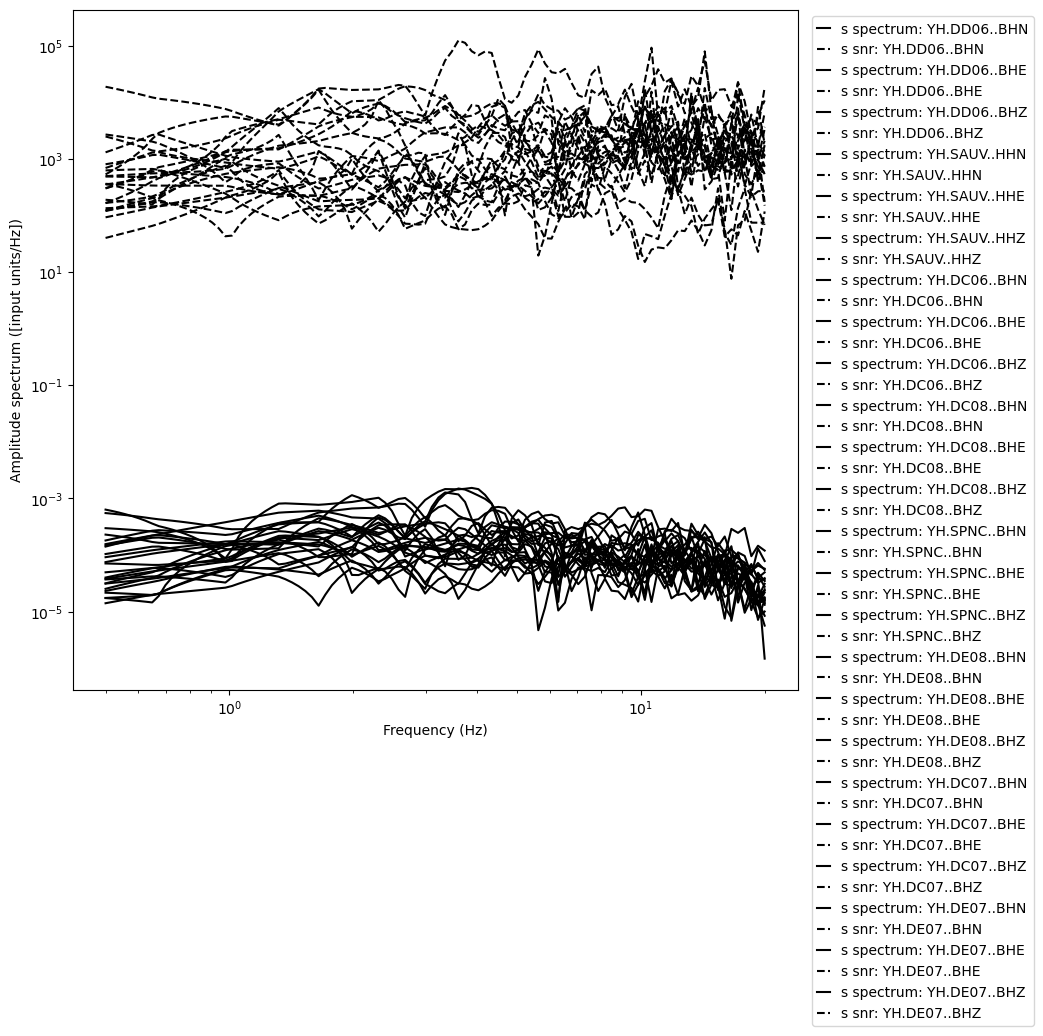

In [9]:
phase_to_plot = "s"
fig = spectrum.plot_spectrum(phase_to_plot, plot_snr=True)

Before correcting for geometrical spreading, we need to build an attenuation model. In general, body-wave attenuation in the lithosphere is described by he quality factor $Q$, which is related to frequency by (Aki, 1980):
$$ Q \propto f^{n},\ 0.5 \leq n \leq 0.8\quad (6)$$

To build a simple model of attenuation, we assume that $Q^P = Q^S = Q_0 f^n$. We search for an adequate value of $Q_0$ and $n$ in the literature. $Q_0 = 33$ and $n = 0.75$ reproduce reasonably well the curves shown in Izgi et al., 2020.

References:

Aki, K. (1980). Attenuation of shear-waves in the lithosphere for frequencies from 0.05 to 25 Hz. Physics of the Earth and Planetary Interiors, 21(1), 50-60.

Izgi, G., Eken, T., Gaebler, P., Eulenfeld, T., & Taymaz, T. (2020). Crustal seismic attenuation parameters in the western region of the North Anatolian Fault Zone. Journal of Geodynamics, 134, 101694.

In [10]:
Q_1Hz = 33.
n = 0.75
Q = Q_1Hz * np.power(spectrum.frequencies, n)

In [11]:
spectrum.attenuation_Q_model(Q, spectrum.frequencies)
spectrum.compute_correction_factor(
    RHO_KGM3, VP_MS, VS_MS,
)


Relative error on M0: 0.00%
Relative error on fc: 2.06%
Relative error on M0: 0.00%
Relative error on fc: 1.56%


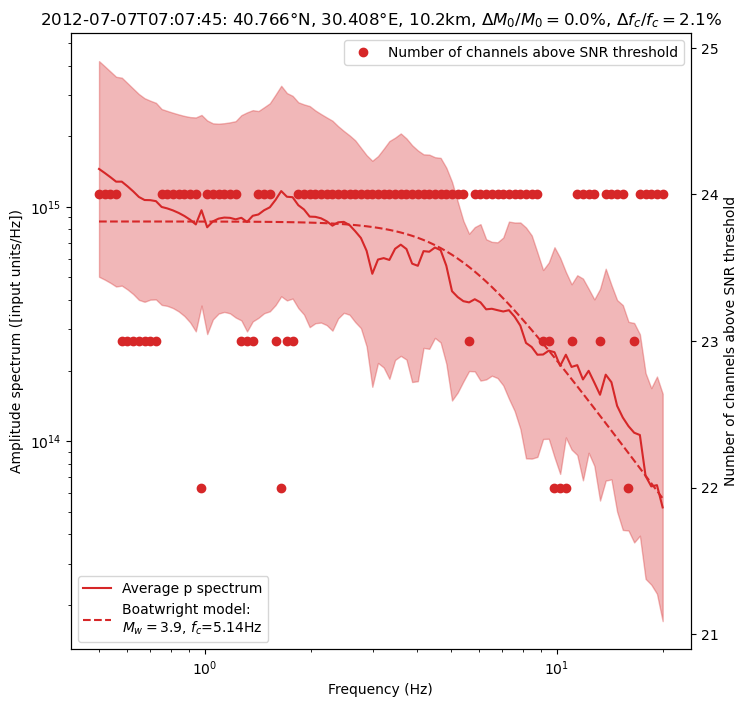

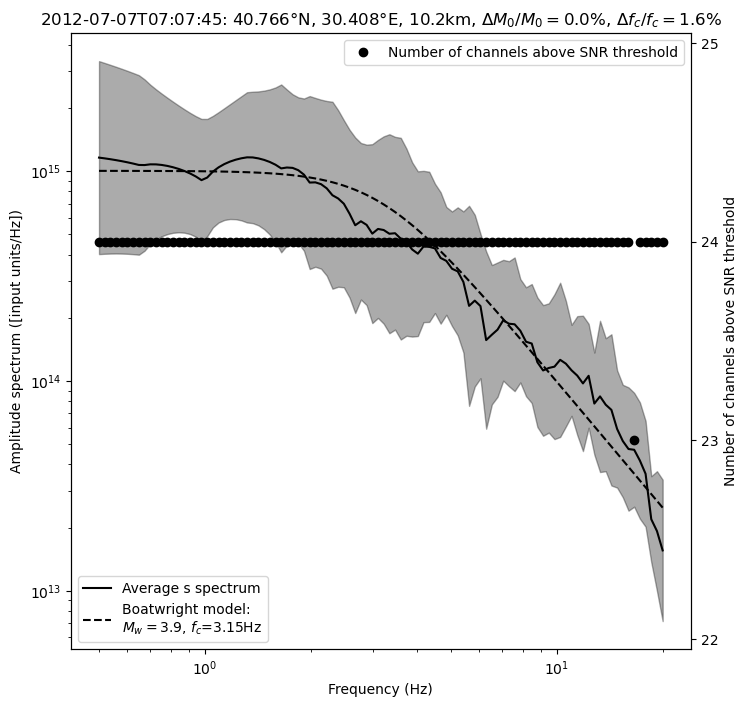

In [12]:
source_parameters = {}
for phase_for_mag in ["p", "s"]:
    spectrum.compute_network_average_spectrum(
        phase_for_mag,
        SNR_THRESHOLD,
        min_num_valid_channels_per_freq_bin=MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN
        )
    spectrum.integrate(phase_for_mag, average=True)
    spectrum.fit_average_spectrum(
            phase_for_mag,
            model=SPECTRAL_MODEL,
            min_fraction_valid_points_below_fc=MIN_FRACTION_VALID_POINTS_BELOW_FC,
            weighted=NUM_CHANNEL_WEIGHTED_FIT,
            )
    if spectrum.inversion_success:
        rel_M0_err = 100.*spectrum.M0_err/spectrum.M0
        rel_fc_err = 100.*spectrum.fc_err/spectrum.fc
        if rel_M0_err > 10. or spectrum.fc < 0. or spectrum.fc > 25.:
            continue
        print(f"Relative error on M0: {rel_M0_err:.2f}%")
        print(f"Relative error on fc: {rel_fc_err:.2f}%")
        # event.set_aux_data({f"Mw_{phase_for_mag}": spectrum.Mw})
        figtitle = (f"{event.origin_time.strftime('%Y-%m-%dT%H:%M:%S')}: "
                    f"{event.latitude:.3f}""\u00b0"
                    f"N, {event.longitude:.3f}""\u00b0"
                    f"E, {event.depth:.1f}km, "
                    r"$\Delta M_0 / M_0=$"f"{rel_M0_err:.1f}%, "
                    r"$\Delta f_c / f_c=$"f"{rel_fc_err:.1f}%")
        source_parameters[f"M0_{phase_for_mag}"] = spectrum.M0
        source_parameters[f"Mw_{phase_for_mag}"] = spectrum.Mw
        source_parameters[f"fc_{phase_for_mag}"] = spectrum.fc
        source_parameters[f"M0_err_{phase_for_mag}"] = spectrum.M0_err
        source_parameters[f"fc_err_{phase_for_mag}"] = spectrum.fc_err
        if (spectrum.Mw > 2.5) or np.random.random() > 0.95:
            fig = spectrum.plot_average_spectrum(
                    phase_for_mag,
                    plot_fit=True,
                    figname=f"{phase_for_mag}_spectrum_{EVENT_IDX}",
                    figtitle=figtitle,
                    figsize=(8, 8),
                    plot_std=True,
                    plot_num_valid_channels=True,
                    )


In [13]:
spectrum.average_s_spectrum["num_valid_channels"].dtype

dtype('int64')

To get a single final estimate of the moment magnitude $M_w$, we average the P- and S-wave estimates. Thus,
$$ M_w = \frac{1}{2} (M_w^P + M_w^S).\quad (7) $$
Using the definition of the moment magnitude, we can derive the following formula for the magnitude error:
$$ d M_w = \frac{1}{3} \left( \frac{dM_0^P}{M_0^P} + \frac{dM_0^S}{M_0^S} \right) $$

In [14]:
Mw_exists = False
norm = 0.
Mw = 0.
Mw_err = 0.
for ph in ["p", "s"]:
    if f"Mw_{ph}" in source_parameters:
        Mw += source_parameters[f"Mw_{ph}"]
        Mw_err += 2./3. * source_parameters[f"M0_err_{ph}"]/source_parameters[f"M0_{ph}"]
        norm += 1
        Mw_exists = True
if Mw_exists:
    Mw /= norm
    Mw_err /= norm
    source_parameters["Mw"] = Mw
    source_parameters["Mw_err"] = Mw_err
else:
    Mw = np.nan
    Mw_err = np.nan

print(f"The P-S averaged moment magnitude is {Mw:.2f} +/- {Mw_err:.2f}")
source_parameters["Mw"] = Mw
source_parameters["Mw_err"] = Mw_err
source_parameters

The P-S averaged moment magnitude is 3.91 +/- 0.00


{'M0_p': 865145436820142.0,
 'Mw_p': 3.89139274763484,
 'fc_p': 5.140117163444819,
 'M0_err_p': 3.9894035571441114e-16,
 'fc_err_p': 0.10585873305949234,
 'M0_s': 1001775760653567.4,
 'Mw_s': 3.9338470127510314,
 'fc_s': 3.153932249621694,
 'M0_err_s': 8.959504561834995e-17,
 'fc_err_s': 0.04914447267225397,
 'Mw': 3.9126198801929357,
 'Mw_err': 1.8352047344806354e-31}

## Repeat the same processing for every event


In [15]:
#         waveform extraction parameters
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP_S = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "S"}
PHASE_ON_COMP_P = {"N": "P", "1": "P", "E": "P", "2": "P", "Z": "P"}
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 0.5, "S": 0.5}
DURATION_SEC = 3.0
OFFSET_OT_SEC_NOISE = DURATION_SEC + 1.0
TIME_SHIFTED = True
DATA_FOLDER = "raw"
DATA_READER = data_reader_mseed
ATTACH_RESPONSE = True

#       spectral inversion parameters
SPECTRAL_MODEL = "boatwright"
RHO_KGM3 = 2700.0
VS_MS = 3500.0
VP_MS = VS_MS * 1.72
FREQ_MIN_HZ = 0.5
FREQ_MAX_HZ = 20.
NUM_FREQS = 100
SNR_THRESHOLD = 10.
MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN = 5
MIN_FRACTION_VALID_POINTS_BELOW_FC = 0.66
NUM_CHANNEL_WEIGHTED_FIT = True

#                   attenuation model
Q_1Hz = 33.
n = 0.75
Q = Q_1Hz * np.power(spectrum.frequencies, n)

Processing event 0
The P-S averaged moment magnitude is 2.69 +/- 0.03
Processing event 1
The P-S averaged moment magnitude is 3.91 +/- 0.00
Processing event 2
The P-S averaged moment magnitude is nan +/- nan
Processing event 3
The P-S averaged moment magnitude is 2.81 +/- 0.02
Processing event 4
The P-S averaged moment magnitude is 2.60 +/- 0.03
Processing event 5
The P-S averaged moment magnitude is nan +/- nan
Processing event 6
The P-S averaged moment magnitude is nan +/- nan
Processing event 7
The P-S averaged moment magnitude is nan +/- nan
Processing event 8
The P-S averaged moment magnitude is nan +/- nan
Processing event 9
Spectrum is below SNR threshold everywhere, cannot fit it.
Spectrum is below SNR threshold everywhere, cannot fit it.
The P-S averaged moment magnitude is nan +/- nan
Processing event 10
The P-S averaged moment magnitude is nan +/- nan
Processing event 11
Spectrum is below SNR threshold everywhere, cannot fit it.
Spectrum is below SNR threshold everywhere, ca

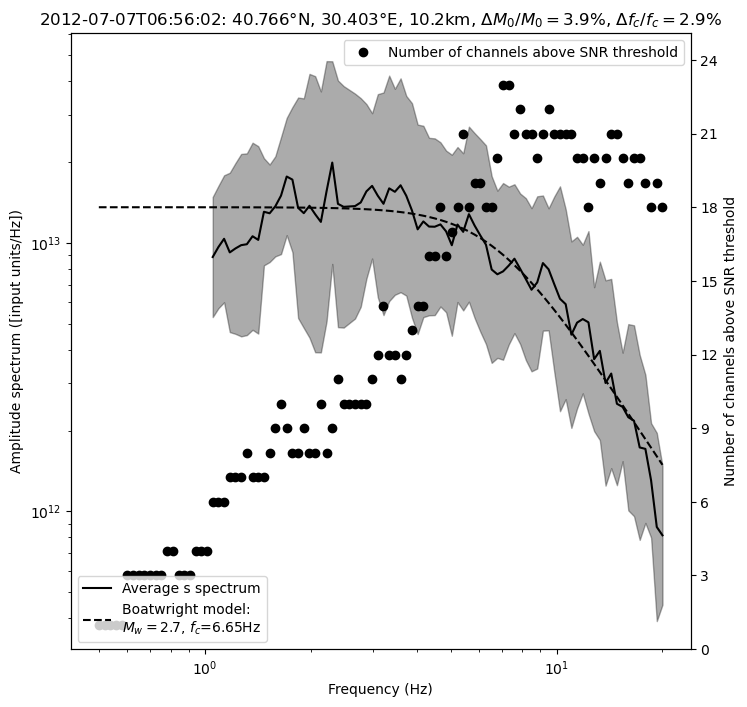

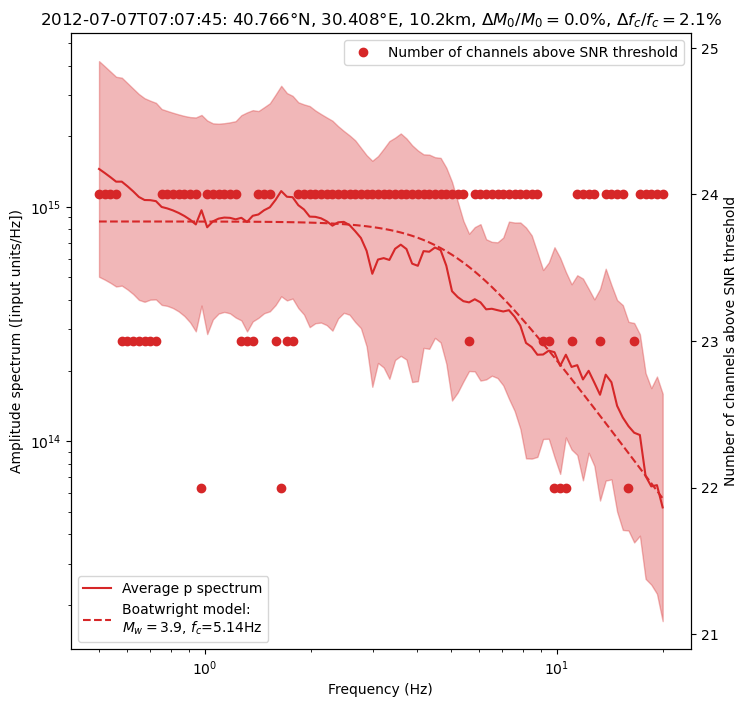

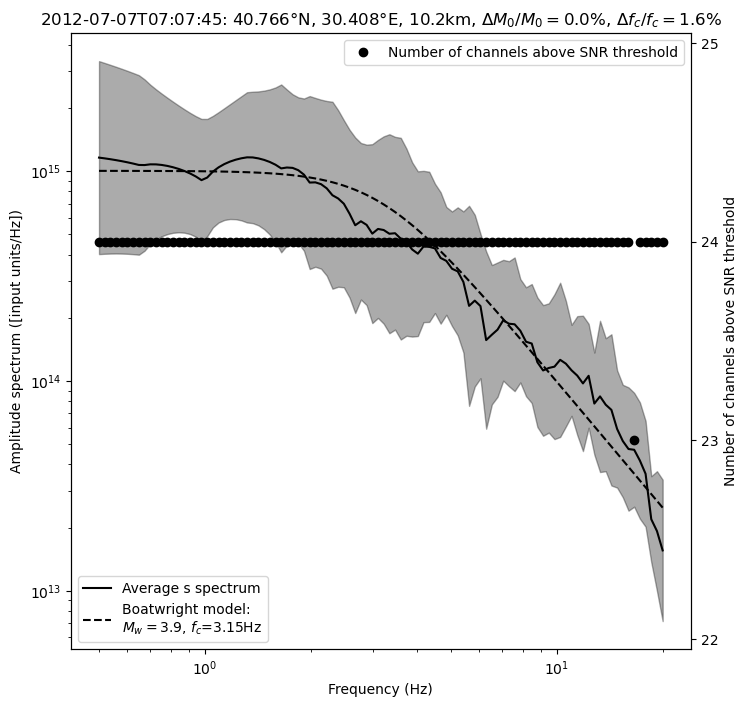

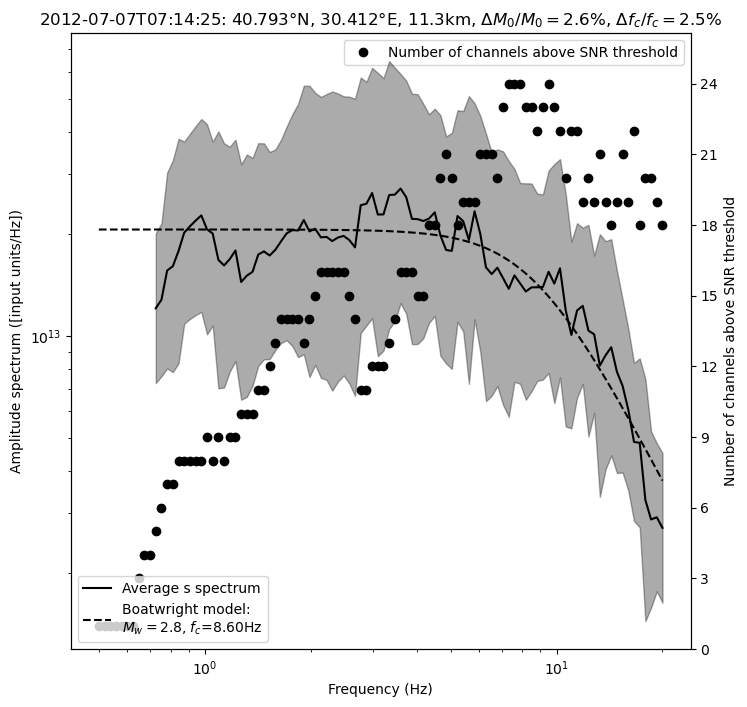

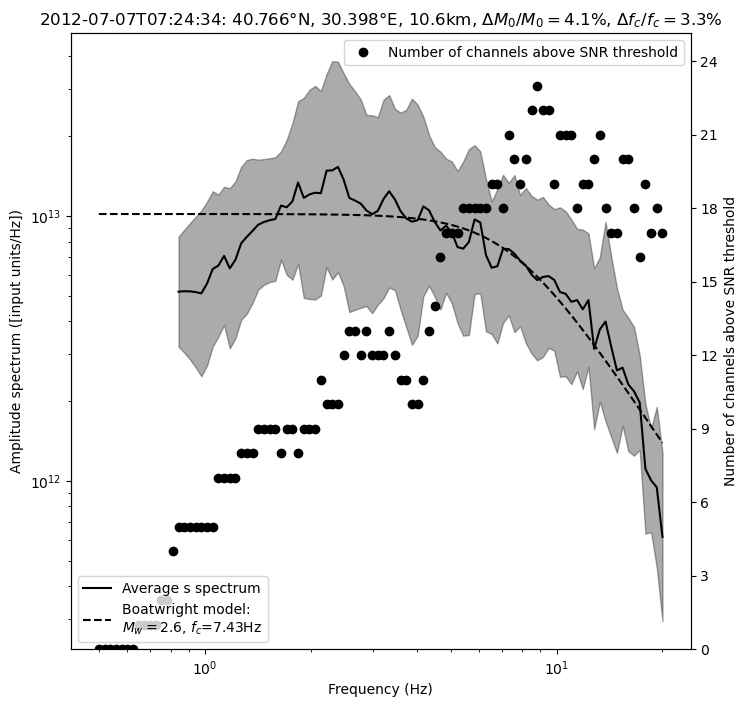

In [16]:
for i, event in enumerate(backprojection_events):
    print("========================")
    print(f"Processing event {i}")
    
    #                 extract waveforms
    # first, read short extract before signal as an estimate of noise
    event.read_waveforms(
        DURATION_SEC,
        time_shifted=False,
        data_folder=DATA_FOLDER,
        offset_ot=OFFSET_OT_SEC_NOISE,
        attach_response=ATTACH_RESPONSE,
    )
    noise = event.traces.copy()
    noise.remove_sensitivity()

    # then, read signal
    event.read_waveforms(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP_P,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
        attach_response=ATTACH_RESPONSE,
    )
    event.traces.remove_sensitivity()
    event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
    p_wave = event.traces.copy()

    event.read_waveforms(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP_S,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
        attach_response=ATTACH_RESPONSE,
    )
    event.traces.remove_sensitivity()
    event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
    s_wave = event.traces.copy()
    
    spectrum = BPMF.spectrum.Spectrum(event=event)
    spectrum.compute_spectrum(noise, "noise")
    spectrum.compute_spectrum(p_wave, "p")
    spectrum.compute_spectrum(s_wave, "s")

    spectrum.set_target_frequencies(FREQ_MIN_HZ, FREQ_MAX_HZ, NUM_FREQS)
    spectrum.resample(spectrum.frequencies, spectrum.phases)
    spectrum.compute_signal_to_noise_ratio("p")
    spectrum.compute_signal_to_noise_ratio("s")

    spectrum.attenuation_Q_model(Q, spectrum.frequencies)
    spectrum.compute_correction_factor(
        RHO_KGM3, VP_MS, VS_MS,
    )

    source_parameters = {}
    for phase_for_mag in ["p", "s"]:
        spectrum.compute_network_average_spectrum(
            phase_for_mag,
            SNR_THRESHOLD,
            min_num_valid_channels_per_freq_bin=MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN
            )
        spectrum.integrate(phase_for_mag, average=True)
        spectrum.fit_average_spectrum(
                phase_for_mag,
                model=SPECTRAL_MODEL,
                min_fraction_valid_points_below_fc=MIN_FRACTION_VALID_POINTS_BELOW_FC,
                weighted=NUM_CHANNEL_WEIGHTED_FIT
                )
        if spectrum.inversion_success:
            rel_M0_err = 100.*spectrum.M0_err/spectrum.M0
            rel_fc_err = 100.*spectrum.fc_err/spectrum.fc
            if rel_M0_err > 10. or spectrum.fc < 0. or spectrum.fc > 25.:
                continue
            # event.set_aux_data({f"Mw_{phase_for_mag}": spectrum.Mw})
            figtitle = (f"{event.origin_time.strftime('%Y-%m-%dT%H:%M:%S')}: "
                        f"{event.latitude:.3f}""\u00b0"
                        f"N, {event.longitude:.3f}""\u00b0"
                        f"E, {event.depth:.1f}km, "
                        r"$\Delta M_0 / M_0=$"f"{rel_M0_err:.1f}%, "
                        r"$\Delta f_c / f_c=$"f"{rel_fc_err:.1f}%")
            source_parameters[f"M0_{phase_for_mag}"] = spectrum.M0
            source_parameters[f"Mw_{phase_for_mag}"] = spectrum.Mw
            source_parameters[f"fc_{phase_for_mag}"] = spectrum.fc
            source_parameters[f"M0_err_{phase_for_mag}"] = spectrum.M0_err
            source_parameters[f"fc_err_{phase_for_mag}"] = spectrum.fc_err
            if (spectrum.Mw > 2.5):
                fig = spectrum.plot_average_spectrum(
                        phase_for_mag,
                        plot_fit=True,
                        figname=f"{phase_for_mag}_spectrum_{i}",
                        figtitle=figtitle,
                        figsize=(8, 8),
                        plot_std=True,
                        plot_num_valid_channels=True,
                        )

    Mw_exists = False
    norm = 0.
    Mw = 0.
    Mw_err = 0.
    for ph in ["p", "s"]:
        if f"Mw_{ph}" in source_parameters:
            Mw += source_parameters[f"Mw_{ph}"]
            Mw_err += 2./3. * source_parameters[f"M0_err_{ph}"]/source_parameters[f"M0_{ph}"]
            norm += 1
            Mw_exists = True
    if Mw_exists:
        Mw /= norm
        Mw_err /= norm
        source_parameters["Mw"] = Mw
        source_parameters["Mw_err"] = Mw_err
    else:
        Mw = np.nan
        Mw_err = np.nan

    print(f"The P-S averaged moment magnitude is {Mw:.2f} +/- {Mw_err:.2f}")
    source_parameters["Mw"] = Mw
    source_parameters["Mw_err"] = Mw_err
    
    # save all this new information in BPMF.dataset.Event.aux_data
    event.set_aux_data(source_parameters)


## Save the final backprojection catalog!

In [17]:
BACKPROJECTION_CATALOG_FILENAME = "backprojection_catalog.csv"

In [18]:
backprojection_catalog = BPMF.dataset.Catalog.read_from_events(
    backprojection_events,
    extra_attributes=["hmax_unc", "hmin_unc", "az_hmax_unc", "Mw", "Mw_err"]
)
backprojection_catalog.catalog

,longitude,latitude,depth,origin_time,hmax_unc,hmin_unc,az_hmax_unc,Mw,Mw_err
0,30.402637,40.765937,10.238281,2012-07-07 06:56:02.560,1.554406,1.320863,-167.389837,2.688609,2.603238e-02
1,30.408496,40.765937,10.238281,2012-07-07 07:07:45.720,1.386711,1.049999,148.121750,3.912620,1.835205e-31
2,30.404590,40.762187,10.136719,2012-07-07 07:12:06.200,1.204078,0.954942,138.520075,NaN,NaN
3,30.411914,40.793125,11.304688,2012-07-07 07:14:25.000,1.886675,1.435720,-163.098388,2.809426,1.748471e-02
4,30.397754,40.765937,10.644531,2012-07-07 07:24:34.000,1.477016,1.028668,137.014524,2.604610,2.720755e-02
5,30.409961,40.768125,10.289062,2012-07-07 07:34:42.800,2.157981,1.659802,125.916805,NaN,NaN
6,30.413867,40.759375,9.273438,2012-07-07 08:17:35.080,1.807823,1.109721,70.558859,NaN,NaN
7,30.445117,40.764375,8.054688,2012-07-07 08:48:43.800,2.982386,1.933982,-169.556250,NaN,NaN
8,30.402637,40.764687,10.035156,2012-07-07 09:20:12.480,1.116928,0.884104,159.472964,NaN,NaN
9,30.316699,40.754688,0.285156,2012-07-07 10:16:39.800,3.378762,1.691182,-143.772340,NaN,NaN


In [19]:
backprojection_catalog.catalog.to_csv(
    os.path.join(BPMF.cfg.OUTPUT_PATH, BACKPROJECTION_CATALOG_FILENAME)
)

In [22]:
for event in backprojection_events:
    event.update_aux_data_database()
BPMF.utils.donefun()

⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⢀⡤⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡀⠀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⢀⡏⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⣀⠴⠋⠉⠉⡆⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠈⠉⠉⠙⠓⠚⠁⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⢀⠞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⠀⠀⠀⠀
    ⠀⠀⠀⠀⡞⠀⠀⠀⠀⠀⠶⠀⠀⠀⠀⠀⠀⠦⠀⠀⠀⠀⠀⠸⡆⠀⠀⠀
    ⢠⣤⣶⣾⣧⣤⣤⣀⡀⠀⠀⠀⠀⠈⠀⠀⠀⢀⡤⠴⠶⠤⢤⡀⣧⣀⣀⠀
    ⠻⠶⣾⠁⠀⠀⠀⠀⠙⣆⠀⠀⠀⠀⠀⠀⣰⠋⠀⠀⠀⠀⠀⢹⣿⣭⣽⠇
    ⠀⠀⠙⠤⠴⢤⡤⠤⠤⠋⠉⠉⠉⠉⠉⠉⠉⠳⠖⠦⠤⠶⠦⠞⠁⠀⠀⠀
                ALL DONE!⠀⠀⠀⠀
    
